In [1]:
from __future__ import division
import numpy as np
import sys
from math import sqrt
from scipy.linalg import norm
from sklearn.base import BaseEstimator
from sklearn.datasets.base import Bunch
from hashlib import sha1

import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt

%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Problem To Be Optimized

$argmin := f(x) + \nabla f(x)(x-x_k) + \frac{L}{2} \|x-x_k\|^2 + g(x) $

where 
* L = Lipschitz Constant
* f = the function 
* g = proximal function
* x_k = the 

## Cost Function (Least Squares) and Gradient:
$argmin(f(x)) := 1/2 * \|Ax-b\|^2$

$\nabla f(x) = A^T(Ax-b)$

## Grad Descent
$x_{k+1} = x_{k} - \alpha*\nabla f(x)$
With $\alpha$ being some step size, could be fixed, or dynamic.

## ISTA
Must first define proximal functions. For example, l1, l2, or elastic net regularization.

$\lambda\|x_{k}\| -> \lambda * S_{k+1}$, where $S_{k+1}$ is the Shrinkage operator wrt to 0.

\begin{align*}
\text{prox}_{\lambda\|\cdot\|_1}(v) & = \text{sign}(v) \odot (|v| − \lambda)_+ \\
\text{prox}_{\lambda\|\cdot\|_2^2}(v) & = \frac{1}{1 + \lambda} v \\
\text{prox}_{\lambda_1\|\cdot\|_1 + \lambda_2 / 2\|\cdot\|_2^2}(v) & = \frac{1}{1 + \lambda_2} \text{sign}(v) \odot (|v| - \lambda_1)_+
\end{align*}

$x_{k+1} = Shrinkage(x_{k} - \alpha * \nabla f(x))_{\alpha*\lambda}$

## FISTA
$x_{k+1} = Shrinkage(y_{k} - \alpha * \nabla f(y))_{\alpha*\lambda}$
$y_{k+1} = x_{k+1} + \frac{t-1}{(1 + (1+4t^2)^{1/2})/2} (x_{k+1} - x{k})$



In [71]:
def prox_l11(u, lambda_):
    """ Proximity operator for l(1, 1, 2) norm
    
    :math:`\\hat{\\alpha}_{l,m} = sign(u_{l,m})\\left||u_{l,m}| - \\lambda \\right|_+`
    Parameters
    ----------
    u : ndarray
        The vector (of the n-dimensional space) on witch we want
        to compute the proximal operator
    lambda_ : float
        regularisation parameter
    Returns
    -------
    ndarray : the vector corresponding to the application of the
             proximity operator to u
    """
    return np.sign(u) * np.maximum(np.abs(u) - lambda_, 0.)

def prox_l22(u, lambda_):
    """ proximity operator l(2, 2, 2) norm
    Parameters
    ----------
     u : ndarray
        The vector (of the n-dimensional space) on witch we want to compute the proximal operator
    lambda_ : float
        regularisation parameter
    Returns
    -------
    ndarray : the vector corresponding to the application of the proximity operator to u
    Notes
    -----
    """
    return 1./(1.+lambda_)*u

def prox_enet(u, lambda1_, lambda2_):
    u_abs = np.abs(u)
    prox_l1 = np.sign(u) * np.maximum(u_abs - lambda1_, 0.)
    return prox_l1 / (1. + lambda2_)

def _load_Lipschitz_constant(A):
    """ 
    Loads the Lipschitz constant and computes it if not already saved. Makes
    the L in (0, 1/||A.T*A||) to ensure convergence
    Parameters
    ----------
    A : 2D-ndarray
        The matrix of witch we want to compute the Lipschitz constant
    Returns
    -------
    float
    Notes
    -----
    Lipshitz constant is just a number < 2/norm(np.dot(K, K.T), 2)
    The constant is stored in a npy hidden file, in the current directory.
    The filename is the sha1 hash of the ndarray
    """
    try:
        mu = np.load('./.%s.npy' % sha1(A).hexdigest())
    except:
        mu = 1/norm(np.dot(A, A.T), 2)
        np.save('./.%s.npy' % sha1(A).hexdigest(), mu)
    return mu

def hinge_step(b, A, Y):
    """
    Returns the point in witch we apply gradient descent
    parameters
    ----------
    y : np-array
        the labels vector
    K : 2D np-array
        the concatenation of all the kernels, of shape
        n_samples, n_kernels*n_samples
    Z : a linear combination of the last two coefficient vectors
    returns
    -------
    res : np-array of shape n_samples*,_kernels
          a point of the space where we will apply gradient descent
    """
    return np.dot(A.transpose(), np.maximum(1 - np.dot(A, Y), 0))

           
def least_square_step(b, A, Y):
    """
    Returns the point in witch we apply gradient descent
    parameters
    ----------
    b : np-array
        the labels vector
    A : 2D np-array
        the concatenation of all the kernels, of shape
        n_samples, n_kernels*n_samples
    Y : a linear combination of the last two coefficient vectors used
        from the extrapolation step
    
    returns
    -------
    res : np-array of shape n_samples, n_features, to 
    """
    return np.dot(A.T, np.dot(A,Y) - b)

In [72]:
class Fista(BaseEstimator):
    '''
    Class: Fast Iterative Shrinkage and Thresholding Algorithm
    
    Used to solve unconstrained minimization of smooth function f in its 
    proximal form:
    
    x_t+1 = argmin{ f(x_t) + grad(f(x_t))*(x-x_t) + 1/(2*mu)*L2(x-x_t)^2}
    
    Parameters:
    1. lambda_: int, optional regularization parameter, default = 0.5
    
    2. loss: 'squared-hinge', 'least-square', optional loss function
    The default = squared-hinge
    
    3. penalty: 'l11', 'l22', optional norm for penalty term
    default = l11
    The first number is the p penalty. The second number is the q penalty.
    
    4. n_iter: int, optonal number of iterations
    default = 1000
    
    5. RECOMPUTE_LIP
    
    '''
    def __init__(self, lambda_=0.5, loss='least-square', penalty='l11', n_iter=1000, RECOMPUTE_LIP=False):
        self.n_iter = n_iter
        self.loss = loss
        self.lambda_ = lambda_
        self.penalty = penalty
        self.RECOMPUTE_LIP = RECOMPUTE_LIP
        
    def fit(self, A, b, Lipschitz_constant=None, verbose=0, **params):
        ''' Fits the estimator
        We want to solve the problem of the form y = KB + b
        with K = n_samples, n_kernels*n_samples matrix
        
        y = Ax - b;
        
        Parameters:
        A: ndarray
        numpy array of shape (n, p)
        where n = number of samples and p = number of features
        
        y:
        
        Lipschitz_constant:
        
        verbose: {0, 1}, optional
        
        '''
        next_step = least_square_step
        if self.loss == 'squared-hinge':
            A = b[:, np.newaxis] * A
            next_step = hinge_step
        
        # determine Lipschitz Constant if none were preset
        if Lipschitz_constant == None:
            Lipschitz_constant = _load_Lipschitz_constant(A)
        
        n_samples, n_features = A.shape
        self.n_samples, self.n_features = n_samples, n_features
        
        tol = 10**(-6)
        
        # INITIAILIZE COEFFICIENTS AND EXTRAPOLATIONS
        # initialize coeffs for features on the current iter and next iter
        coefs_current = np.zeros(n_features, dtype=np.float) 
        coefs_next = np.zeros(n_features, dtype=np.float) 
        
        # Y = x_k + (tk-1)/(t_{k+1}) * (x_k - x_{k-1})
        Y = np.copy(coefs_next) # linear comb of coefficients
        
        # initialize step size
        tau_next = 1
        
        # set the lambda term for FISTA = lambda*L
        if self.penalty=='l11':
            # sets lambda = lambda*L
            prox = lambda(u):prox_l11(u, self.lambda_*Lipschitz_constant)
        elif self.penalty=='l22':
            prox = lambda(u):prox_l22(u, self.lambda_*Lipschitz_constant)
            
        # loop through iterations
        cost = np.zeros((self.n_iter, 1))
        for i in range(self.n_iter):
            ## 01: Compute Iteration On Proximal Step
            coefs_current = coefs_next # X_(k-1) = X_(k)
            coefs_next = prox(Y - Lipschitz_constant*next_step(b, A, Y))

            ## 02: Compute Step Size t_{k+1}
            tau_current = tau_next
            tau_next = (1 + sqrt(1 + 4*tau_current**2))/2 
            step_size = (tau_current - 1) / tau_next
            
            ## 03: Compute Extrapolation Y_{k+1}
            Y = coefs_next + step_size * (coefs_next - coefs_current)
            
            # Compute Objective Function
            penalization = self.lambda_ * norm(coefs_next, 1)
            cost[i] = 0.5 * norm(np.dot(A,coefs_next) - b, 2) + penalization
            
        self.coefs = coefs_next # set the coefficients computed from FISTA
        self.cost = cost
        
        return self
    
    def plot(self):
        fig = plt.figure()
        ax = plt.gca()
        plt.plot(self.cost)
        plt.xlabel('Iteration Count')
        plt.ylabel('Objective Function Evaluation')
        plt.title('')
        plt.tight_layout()
        plt.show()

    def predict(self, A):
        '''
        Parameters
        ----------
        A : ndarray 
            ndarray of size (n_samples, n_kernels*n_samples) representing the kernels
        Returns
        -------
        ndarray : the prediction associated to A
        '''
        if self.loss=='squared-hinge':
            res = np.sign(np.dot(A, self.coefs))
            res[res==0] = 1
            return res
        else:
            return np.dot(A, self.coefs)
    
    def score(self, A, b):
        """ Returns the score prediction for the given data
        Parameters
        ----------
        K : ndarray
            matrix of observations
        y : ndarray
            the labels correspondings to K
        Returns
        -------
        The percentage of good classification for K
        """
#         if self.loss=='squared-hinge':
        return np.sum(np.equal(self.predict(A), b))*100./len(y)
#         else:
#             print "Score not yet implemented for regression\n"
#             return None

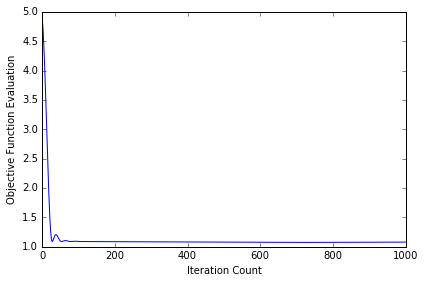

pourcentage de bonne prediction avec l11:   0 
0.0


In [73]:
from sklearn.datasets import load_iris

data = load_iris()

y = data.target
X = data.data

X = X[y<2]
y = y[y<2]
y[y==0] = -1

K1 = X[:, 0]
K2 = X[:, 1]
K3 = X[:, 2]
K4 = X[:, 3]

K1 = np.dot(K1[:, np.newaxis], K1[:, np.newaxis].transpose())
K2 = np.dot(K2[:, np.newaxis], K2[:, np.newaxis].transpose())
K3 = np.dot(K3[:, np.newaxis], K3[:, np.newaxis].transpose())
K4 = np.dot(K4[:, np.newaxis], K4[:, np.newaxis].transpose())
A = np.concatenate((K1, K2, K3, K4), axis=1)
b = y

fista = Fista(lambda_=0.2, loss='least-square', penalty='l11', n_iter=1000)
fista.fit(A, b)
fista.plot()
print "pourcentage de bonne prediction avec l11: %3d " % fista.score(A, b)
print fista.score(A, b)
# print './.%s.npy' % sha1(A).hexdigest(), mu


# ISTA 

Now try the same algorithm with ISTA and compare convergence rate

In [74]:
def least_squares_grad(x, features, labels):
    """Evaluates the gradient of the least square function."""
    n_samples, n_features = features.shape
    x = x.reshape(1, n_features)  # Added for scipy.optimize compatibility
    grad_array = (np.dot(features, x.T) - labels).dot(features)
    return np.sum(grad_array, axis=0) / n_samples

def least_squares(x, features, labels):
    n_samples = features.shape[0]
    x = x.reshape(1, n_features)
    loss_array = (features.dot(x.T) - labels) ** 2
    return np.sum(loss_array, axis=0) / (2. * n_samples)

In [75]:
def gd(x_init, grad, n_iter=100, step=1., callback=None):
    """Basic gradient descent algorithm."""
    x = x_init.copy()
    
    for _ in range(n_iter):
        x -= step * grad(x)
        
        # Update metrics after each iteration.
        if callback is not None:
            callback(x)
    return x

def ista(x_init, grad, prox, n_iter=100, step=1., callback=None):
    """ISTA algorithm."""
    x = x_init.copy()
    
    for _ in range(n_iter):
        x = prox(x - step * grad(x), step)
        
        # Update metrics after each iteration.
        if callback is not None:
            callback(x)
    return x

In [76]:
data = load_iris()

y = data.target
X = data.data
X = X[y<2]
y = y[y<2]
y[y==0] = -1

K1 = X[:, 0]
K2 = X[:, 1]
K3 = X[:, 2]
K4 = X[:, 3]

K1 = np.dot(K1[:, np.newaxis], K1[:, np.newaxis].transpose())
K2 = np.dot(K2[:, np.newaxis], K2[:, np.newaxis].transpose())
K3 = np.dot(K3[:, np.newaxis], K3[:, np.newaxis].transpose())
K4 = np.dot(K4[:, np.newaxis], K4[:, np.newaxis].transpose())
A = np.concatenate((K1, K2, K3, K4), axis=1)

n_samples, n_features = A.shape
b = y

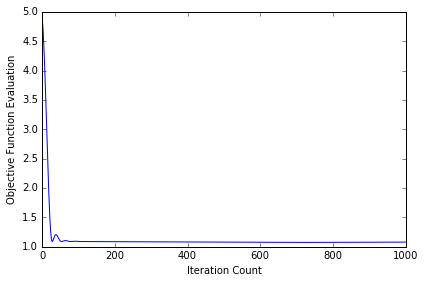

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in maximum


In [83]:
fista = Fista(lambda_=0.2, loss='least-square', penalty='l11', n_iter=1000)
fista.fit(A, b)
fista.plot()
# print "pourcentage de bonne prediction avec l11: %3d " % fista.score(A, b)
# print fista.score(A, b)
# # print './.%s.npy' % sha1(A).hexdigest(), mu

# Initialize stuff
x_init = 1 - 2 * np.random.rand(1, n_features)
n_iter = 1000
labels = b
features = A

# set up gradient, proximal and step size, -> ista
grad_f = lambda x: least_squares_grad(x, A, b)
prox_g = lambda x, lambda_: prox_l11(x, lambda_=0.3)
step = norm(features.T.dot(features) / n_samples, 2)
x_ista = ista(x_init, grad=grad_f, prox=prox_g, n_iter=n_iter, step=step)
